In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
B = torch.randn(5,5)
B = B @ B.T
B

tensor([[ 5.9895,  2.2017,  2.8765,  0.9666,  2.1012],
        [ 2.2017,  3.1882,  2.1027, -0.2515,  0.5914],
        [ 2.8765,  2.1027,  3.7213,  2.0423,  3.1695],
        [ 0.9666, -0.2515,  2.0423,  2.8841,  3.3977],
        [ 2.1012,  0.5914,  3.1695,  3.3977,  6.5016]])

In [3]:
torch_make_off_diag_nonpositive(B)

tensor([[ 5.9895,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  3.1882,  0.0000, -0.2515,  0.0000],
        [ 0.0000,  0.0000,  3.7213,  0.0000,  0.0000],
        [ 0.0000, -0.2515,  0.0000,  2.8841,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  6.5016]])

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [6]:
activation = hard_sigmoid
architecture = [784, 500, 10]

x,y = next(iter(train_loader))
x = x.view(x.size(0),-1).to(device).T
y_one_hot = F.one_hot(y, 10).to(device).T

beta = 1
lambda_ = 0.9999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([0.275, 0.1]), 'fb': np.array([0.05, 0.01])}

neural_lr_start = 0.05
neural_lr_stop = 0.001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 10
neural_dynamic_iterations_free = 20
make_B_off_diag_nonpositive = True

model = ContrastiveCorInfoMax(architecture = architecture, lambda_ = lambda_, 
                              epsilon = epsilon, activation = activation)

In [7]:
_ = evaluateContrastiveCorInfoMax(model, train_loader, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                  neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.10203333333333334


In [8]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 10

for epoch_ in range(n_epochs):
    lr = {'ff' : lr_start['ff'] * (0.99)**epoch_, 'fb' : lr_start['fb'] * (0.99)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        if True:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step(  x, y_one_hot, lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                     neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                     neural_dynamic_iterations_nudged, beta, make_B_off_diag_nonpositive)
    
    trn_acc = evaluateContrastiveCorInfoMax(model, train_loader, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                            neural_lr_decay_multiplier, neural_dynamic_iterations_free, device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMax(model, test_loader, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                            neural_lr_decay_multiplier, neural_dynamic_iterations_free, device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [00:43, 69.10it/s]
7it [00:00, 64.16it/s]

Epoch : 1, Train Accuracy : 0.9219833333333334, Test Accuracy : 0.9246


3000it [00:43, 69.66it/s]
7it [00:00, 63.58it/s]

Epoch : 2, Train Accuracy : 0.9257833333333333, Test Accuracy : 0.9266


3000it [00:42, 70.57it/s]
7it [00:00, 64.44it/s]

Epoch : 3, Train Accuracy : 0.93535, Test Accuracy : 0.9364


3000it [00:42, 69.77it/s]
7it [00:00, 63.65it/s]

Epoch : 4, Train Accuracy : 0.9404666666666667, Test Accuracy : 0.9417


3000it [00:43, 69.43it/s]
7it [00:00, 64.32it/s]

Epoch : 5, Train Accuracy : 0.9448333333333333, Test Accuracy : 0.9452


3000it [00:43, 69.12it/s]
7it [00:00, 63.54it/s]

Epoch : 6, Train Accuracy : 0.9435833333333333, Test Accuracy : 0.9411


3000it [00:43, 69.40it/s]
7it [00:00, 64.51it/s]

Epoch : 7, Train Accuracy : 0.9444666666666667, Test Accuracy : 0.9422


3000it [00:42, 70.20it/s]
7it [00:00, 64.11it/s]

Epoch : 8, Train Accuracy : 0.9096166666666666, Test Accuracy : 0.9121


3000it [00:42, 70.05it/s]
7it [00:00, 63.59it/s]

Epoch : 9, Train Accuracy : 0.9091166666666667, Test Accuracy : 0.9098


3000it [00:42, 70.19it/s]


Epoch : 10, Train Accuracy : 0.9065833333333333, Test Accuracy : 0.9081


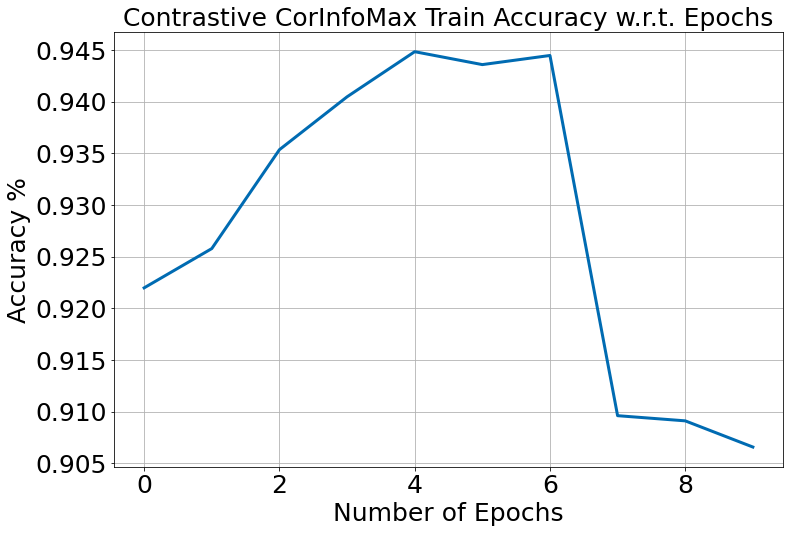

In [9]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

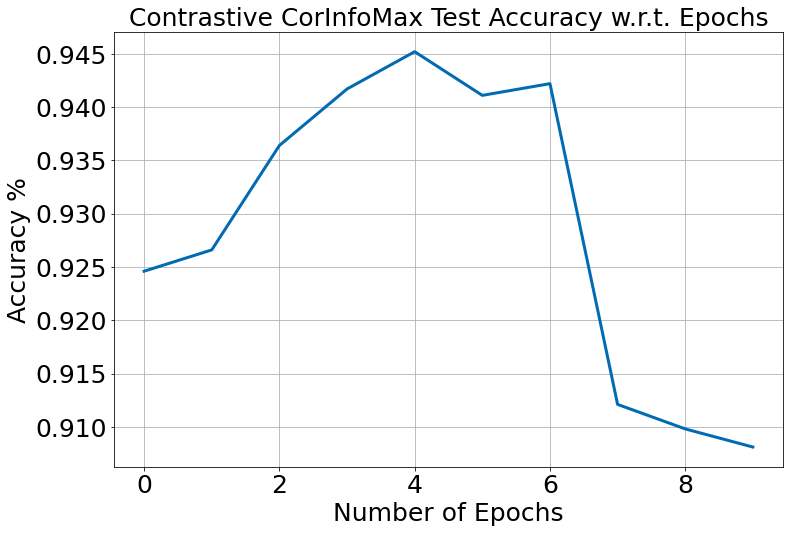

In [10]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [17]:
from IPython.display import Math, display
########### LATEX Style Display Matrix ###############
def display_matrix(array):
    """Display given numpy array with Latex format in Jupyter Notebook.
    Args:
        array (numpy array): Array to be displayed
    """
    data = ""
    for line in array:
        if len(line) == 1:
            data += " %.3f &" % line + r" \\\n"
            continue
        for element in line:
            data += " %.3f &" % element
        data += r" \\" + "\n"
    display(Math("\\begin{bmatrix} \n%s\\end{bmatrix}" % data))

In [18]:
display_matrix(model.B[0]['weight'][:10,:10])

<IPython.core.display.Math object>

In [19]:
torch.diag(model.B[0]['weight'])

tensor([-2.7443e+08, -9.3718e+08, -6.1688e+06, -2.4171e+08, -2.1807e+10,
        -2.1286e+07, -3.4892e+09, -1.1970e+09, -1.6516e+09, -2.3709e+07,
        -1.4476e+01, -5.0934e+09, -2.8789e+09, -1.0854e+09, -3.0628e+09,
        -1.5784e+09, -2.9830e+08, -4.5644e+08, -2.1969e+08, -4.7265e+02,
        -1.1863e+07, -2.1374e+04, -8.4137e+06, -1.8240e+08, -1.7553e+09,
        -8.8859e+07, -1.7702e+09, -3.5712e+08, -2.8351e+02, -4.5711e+02,
        -3.7656e+09, -2.5739e+09, -1.9949e+08, -9.8297e+08, -2.3520e+09,
        -1.1102e+09, -3.5799e+09, -2.0364e+02, -1.9302e+09, -8.6313e+08,
        -1.3692e+03, -5.5992e+03, -3.3322e+04, -5.3592e+09, -9.0994e+08,
        -1.9070e+08, -9.4599e+09,  9.5451e+00, -2.1936e+02, -4.1137e+08,
        -6.7246e+09, -5.9999e+07, -1.2775e+09, -3.2863e+08, -8.1341e+08,
        -1.5558e+08, -3.2082e+09, -5.3070e+07, -5.5407e+08, -1.0125e+10,
        -3.0374e+07, -5.7146e+09, -2.5161e+09, -9.2520e+07, -1.5229e+08,
         1.0256e+01, -1.6262e+02, -1.2455e+06, -3.7

In [54]:
model.Bhdiag_list[-24900]

tensor([1.6216, 1.6204, 1.6566, 1.6510, 1.0724, 1.6473, 1.5396, 1.5915, 1.5851,
        1.5965, 1.6182, 1.5105, 1.5523, 1.6130, 1.5513, 1.5936, 1.6445, 1.6321,
        1.6475, 1.6392, 1.6176, 1.6601, 1.6593, 1.6216, 1.5632, 1.6180, 1.6030,
        1.6331, 1.6218, 1.6043, 1.5207, 1.5662, 1.6260, 1.5937, 1.5648, 1.6246,
        1.5588, 1.6589, 1.5952, 1.6312, 1.6182, 1.6276, 1.6276, 1.5008, 1.6183,
        1.6277, 1.3633, 1.6085, 1.5921, 1.6245, 1.4553, 1.6257, 1.5971, 1.6262,
        1.6133, 1.6428, 1.5389, 1.6163, 1.6283, 1.3833, 1.6149, 1.4713, 1.5728,
        1.6287, 1.6273, 1.6011, 1.6075, 1.6654, 1.5930, 1.6091, 1.6437, 1.5363,
        1.6335, 1.6032, 1.6500, 1.5850, 1.6179, 1.6605, 1.6624, 1.3925, 1.5992,
        1.6623, 1.5681, 1.3768, 1.5841, 1.5969, 1.6239, 1.4965, 1.6304, 1.5992,
        1.5117, 1.5493, 1.6159, 1.6341, 1.5981, 1.6647, 1.6600, 1.6091, 1.6092,
        1.5804, 1.6366, 1.5677, 1.6292, 1.4010, 1.4026, 1.6448, 1.1960, 1.5069,
        1.6521, 1.5037, 1.6019, 1.6653, 

In [14]:
# display_matrix(torch.linalg.inv(model.Rh1)[:10,:10])

In [15]:
# torch.norm(model.B[0]['weight'] - torch.linalg.inv(model.Rh1))

In [16]:
# display_matrix(torch.linalg.inv(model.Rh2)[:10,:10])